# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

Code enriched with interpreatation and useful information to understand how to develop an application based on Technical Analysis and Vectorized backtesting. 

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Trading Strategies (a)

## Simple Moving Averages

### Data Import

In [11]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

Trading based on simple moving averages (SMAs) is a decades-old tradiung approach (see, for example the paper by Brock et. al 1992). Although many traders use SMAs for their discretionary trading, they can also be used to formule simple algorithmic trading strategies. 
This section uses SMAs to introduce vectorized backtesting of algorithmic trading strategies.

In [12]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [13]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [14]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
AAPL.O    2138 non-null float64
MSFT.O    2138 non-null float64
INTC.O    2138 non-null float64
AMZN.O    2138 non-null float64
GS.N      2138 non-null float64
SPY       2138 non-null float64
.SPX      2138 non-null float64
.VIX      2138 non-null float64
EUR=      2216 non-null float64
XAU=      2211 non-null float64
GDX       2138 non-null float64
GLD       2138 non-null float64
dtypes: float64(12)
memory usage: 225.1 KB


In [19]:
symbol = 'AAPL.O'

In [20]:
data = (
    pd.DataFrame(raw[symbol])
    .dropna()
)

### Trading Strategy

The calculation of the SMA values for two different rolling window sizes. 

In [21]:
SMA1 = 42  
SMA2 = 252  

In [22]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()  
data['SMA2'] = data[symbol].rolling(SMA2).mean()  

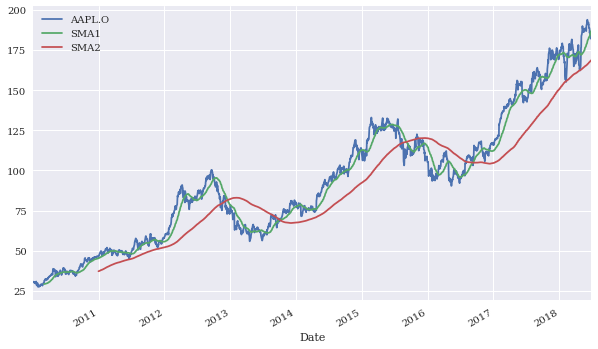

In [23]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_01.png')

Figure: Apple stock price and two simple moving averages

The trading rules are:
- Go Long (= +1) when the shorter SMA is above the longer SMA
- Go Short (= -1) when the shorter SMA is below the longer SMA

In [24]:
data.dropna(inplace=True)

In [25]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)  

In [26]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


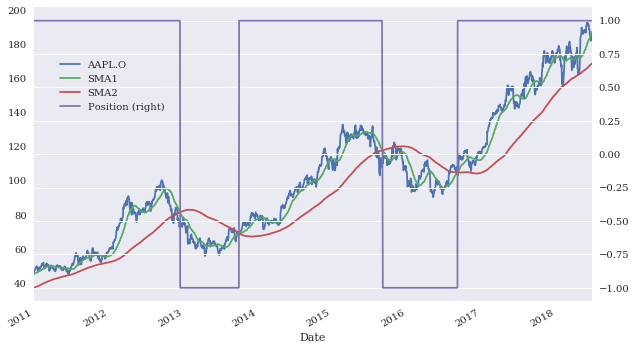

In [27]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_02.png')

Figure: Apple stock price, two SMAs, and resulting positions

This is a technical analysis example. Rolling statistic are a major tool in the so-called tehnical analysis of stocks, as a compared to the funamental analysis which focuses, for instance, on financial reports and the strategic positions of the company whose stock is being analysed.

### Vectorized Backtesting

The vectorized backtesting can now be implemented as follows. First, the log returns are calculated. Then the positions, represented as +1 or -1, are multiplied by the relevant log return. This simple calculation is possible since a long position earns the return of the Apple stock and a short position earns the negative return of the Apple stock. Finally, the  log returns for the Apple stock and the algorithmic trading strategy based on the SMAs need to be added up and the exponential function applied to arrive at performance values:

In [28]:
# Calculates the log returns of the Apple stock (i.e. the benchmark investment)
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [29]:
# Multiplies the position values, shifted by one day, by the log returns of the Apple stock;
# the shift is required to avoid foresight bias. 
data['Strategy'] = data['Position'].shift(1) * data['Returns']  

In [16]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [30]:
data.dropna(inplace=True)

In [31]:
# Sums up the log returns for the strategy and the benchmark investment and calculates
# the exponential value to arrive at the absolute performance
np.exp(data[['Returns', 'Strategy']].sum())  

Returns     4.017148
Strategy    5.811299
dtype: float64

In [32]:
# Calculates the annualized volatility for the strategy and the benchmark investment
data[['Returns', 'Strategy']].std() * 252 ** 0.5  

Returns     0.250571
Strategy    0.250407
dtype: float64

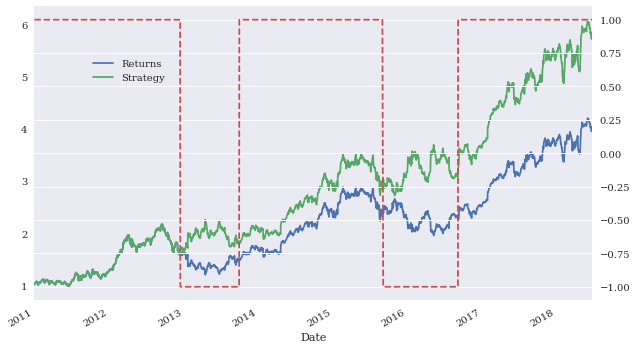

In [33]:
ax = data[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_03.png');

Figure: Performance of th Apple stock and SMA-based trading strategy over time

The vectorized backtesting approach as introduced in this subjection is based on the number of simplifying assumptions. Among others, transactions cosdts (fixed fees, bid-ask spreads, lending costs, etc) are not included. This might be justificable for a trading strategy that leads to the few trades only over multiple years. It is also assumed that all trades take place at the end-of-day closing prices for the Apple stock. A more realistic backtesting approach would take these and other (market microstructure) elemenents into account. 

### Optimization

A natural question that arises is if the chosen parameters for SMA1 = 42 and SMA2 = 252 are the "right" ones. In general, investors prefer higher returns to lower returns ceteris paribus. 
Therefore, one might be inclined to search for those parameters that maximize the return over the relevant period. To this end, a brute force apporach can be used that simply repeats the whole vectorized backtesting procedure for different parameter combinations, record the results and does a raning afterwards. This is what the following code does:

In [34]:
from itertools import product

In [35]:
# Specifies the parameter values for SMA1 and SMA2
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10)  

In [36]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    # Records the vectorized backtesting results in a Dataframe object. 
    results = results.append(pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'OUT': perf['Strategy'] - perf['Returns']},
                 index=[0]), ignore_index=True)  

In [37]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
SMA1        121 non-null int64
SMA2        121 non-null int64
MARKET      121 non-null float64
STRATEGY    121 non-null float64
OUT         121 non-null float64
dtypes: float64(3), int64(2)
memory usage: 4.8 KB


In [38]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


According to the brute force-based optimization, SMA1=40 and SMA2=90 are the optimal parameters, leading to an outperformance of some 230 points. However. this result is heavility dependent on the data set used and is prone to overfitting. A more rigorous approach would be to implement the optimization on one dataset, the in-sample or training dataset, and test it on another one, the out-of-sample or testing data set. 

## Random Walk Hypothesis

The previous section introduces vectorized backtesting as an efficient tool to backtest algorithmic trading strategies. The single strategy backtested based on a simple financial time series, namely historical of simple going long on the Apple stock over the same period. 

Although rather specific in nature, these results are in contrast to what the random walk hypothesis (RWH) predicts, namely that such predictive approached should not yield any outperformance at all. THe RWH postulates that prices in the financial markets follow a random walk, or, in continuous time, an arithmetic Brownian motion without drift. The expected value of an arithmetic Brownian motion drift at any point in the future equals its value today. As consequence, the best predictor for tomorrow's price, in a least-squares sense, is today's price, in a least-squares sense, is today's price if the RWH applies. 

Using Python, the RWH can be tested for a specific case as follows. A financial time series of historical market prices is used for which a number of lagged versions are created- say, five. OLS regression is then used to predict the market prices bases on the lagged market prices created before. The basic idea is that the market prices from yesterday and four more days back can be used to predict today's market price. 

The following Python code implements this idea and creates five lagged versions of of historical end-of-day closing levels of the S&P500 stock index:

In [40]:
symbol = '.SPX'

In [41]:
data = pd.DataFrame(raw[symbol])

In [42]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    # Defines a columns name for the current lag velue
    col = 'lag_{}'.format(lag)  
    # Creates a lagged version of the market prices for the currrent lag value
    data[col] = data[symbol].shift(lag) 
    # Collects the column names for later reference
    cols.append(col)  

In [43]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


In [44]:
data.dropna(inplace=True)

In [45]:
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0]

In [46]:
reg.round(3)

array([0.966, 0.005, 0.025, 0.   , 0.003])

Using Numpy, the OLS regression is straightforward to implement. As the optimal regression parameters show, lag_1 indeed is the most popular one in predicting the market price based on OLS regression. Its value is close to 1. The other four values are rather close to 0. 

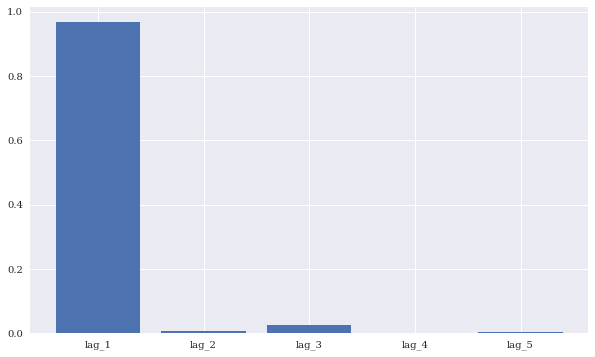

In [47]:

plt.figure(figsize=(10, 6))
plt.bar(cols, reg);
# plt.savefig('../../images/ch15/strat_plot_04.png');

Figure: Optimal regression parameter from OLS regression for price prediction

In [48]:
data['Prediction'] = np.dot(data[cols], reg)

When using the optimal results to visualize the prediction values as compared to the original index values for the S&P 500, it becomes obvious from Figure below that indeed lag_1 is basically what is used to come up with the prediction value. Graphically speaking, the prediction line in the Figure is the original time series shifted by one day to the right. 

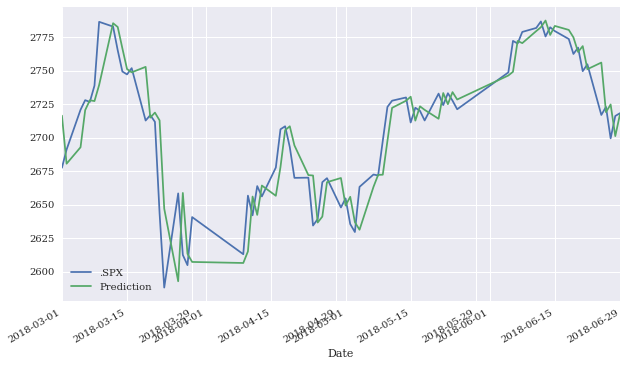

In [49]:
data[[symbol, 'Prediction']].iloc[-75:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_05.png');

figure: S&P500 levels compared to prediction values from OLS regression. 

All in all, the brief analysis in this section reveals some support for both the RWH and the EMH. For sure, the anylsis is done for a single stock index only and uses a rather specific parameterization- but this can easily be widened to incorporate multiple financial instruments across multiple asset classes, different values for the numner of lags, etc. In general, one will find out that the results are qualitatevily more or less the same. After all, the RWH and EMH are among the financial theoiries that have broad empirical support. In that sense, any algorithmic trading strategy must prove its worth by providing that the RWH does not apply in general. This for sure is a tough hurdle.

See next notebook for see the second part of the analysis. 